
## Gamma as Posterior Example
We go back to original Poisson Example

Prior is Gamma($\alpha$,$\beta$) , and we obeserve $y_1,y_2...,y_n$ for each pair of theta
 - Prior : $\theta \sim Gamma(\alpha_0,\beta_0)$
 - Likelihood:
    $y_i\sim Poisson(\theta)$, i = 1,...,N

By conjugacy, the posterior will also be a Gamma distribution , and we are using a Normalising flow from standard normal distribution to this posterior

$$\theta \mid \mathbf{y} \sim \mathrm{Gamma} \left( \alpha_0 + \sum_{i} y_i,\, \beta_0 + N \right)
$$

### Adding Structural loss to our Total loss


In this version , we upgrade our model with larger M, and traning with log $\theta$

### Previous Loss
$ \mathcal{L}_{\text{NLL}} = -\frac{1}{M} \sum_{i=1}^{M} \log \left( \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(\theta_i \mid \mu_k, \sigma_k^2) \right)$

### Updated Loss
$$
\mathcal{L}_{\text{updated}} = 
-\frac{1}{M} \sum_{i=1}^{M} \log\left( \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(\theta_i \mid \mu_k, \sigma_k^2) \right)
+ \lambda_{\text{struct}} \cdot \mathbb{E}_{\theta \sim q_{\text{MDN}}} \left[ \log q_{\text{MDN}}(\theta) - \log \mathcal{N}(\theta \mid \widehat{\theta}_{\text{MLE}}, \widehat{\sigma}^2_{\text{Fisher}}) \right]
$$




### First code describes the Lambda = 0

We set $\lambda$ to be zero, because we want to check the effect of not considering the distance between our MDN and target distribution.

In this case, our loss would simply be our negative log-likelihood, which is already been done in Week 3, where we use the sufficient statistics.

We want to see , if we add the new loss, would it still capture the shape when N is very large?

We want to compare the different effect between different weights of our loss, and hence we can answer the question: "Do we actually need to memorise the shape, or can we just let neural network to learn from it?"




Epoch 0, Loss: 41133.87891
Epoch 100, Loss: 707.76068
Epoch 200, Loss: 263.45135
Epoch 300, Loss: 183.71454
Epoch 400, Loss: 176.44838
Epoch 500, Loss: 185.63998
Epoch 600, Loss: 283.80478
Epoch 700, Loss: 144.72269
Epoch 800, Loss: 140.64653
Epoch 900, Loss: 226.35956


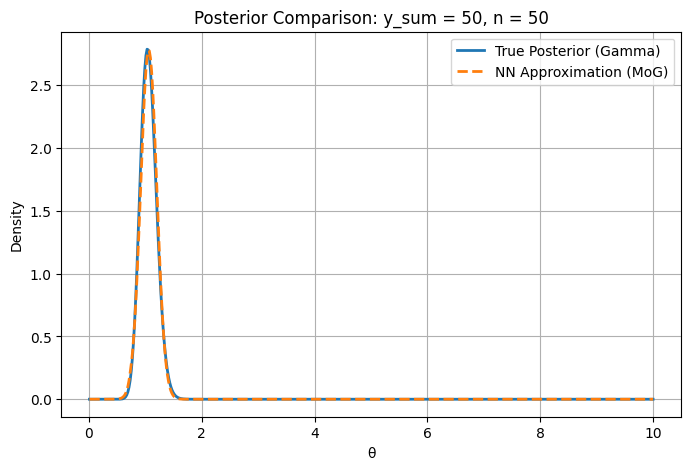

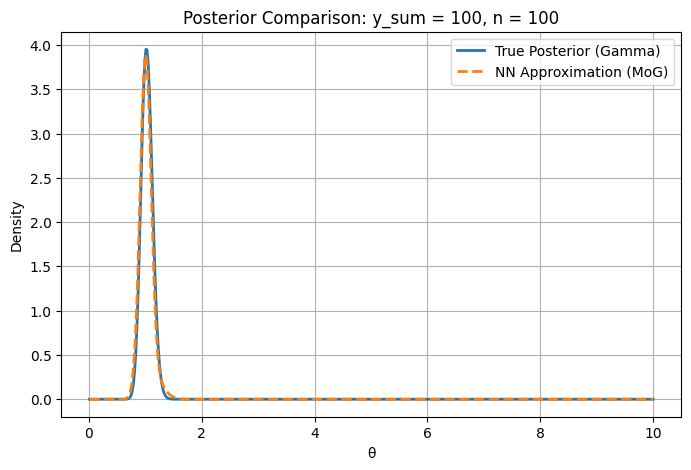

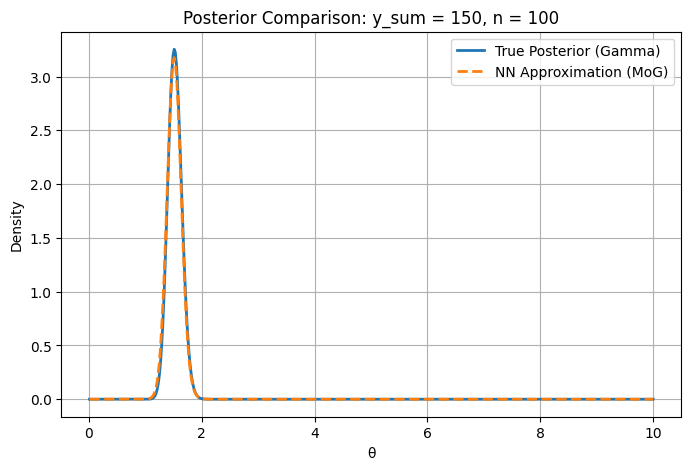

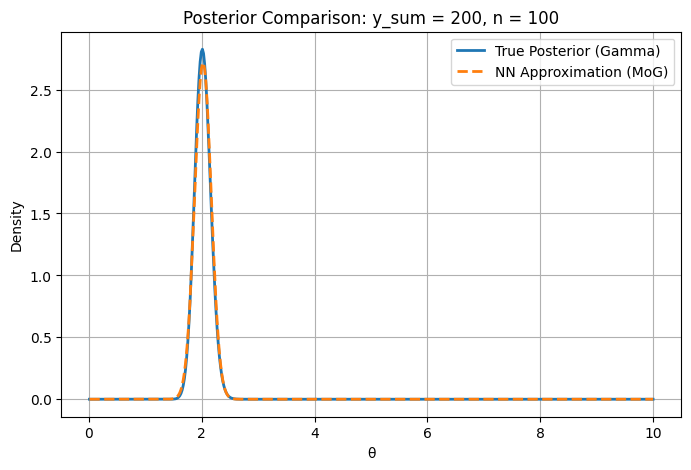

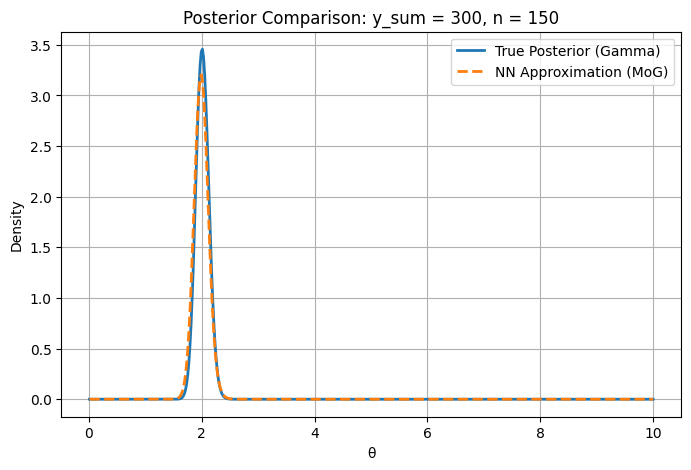

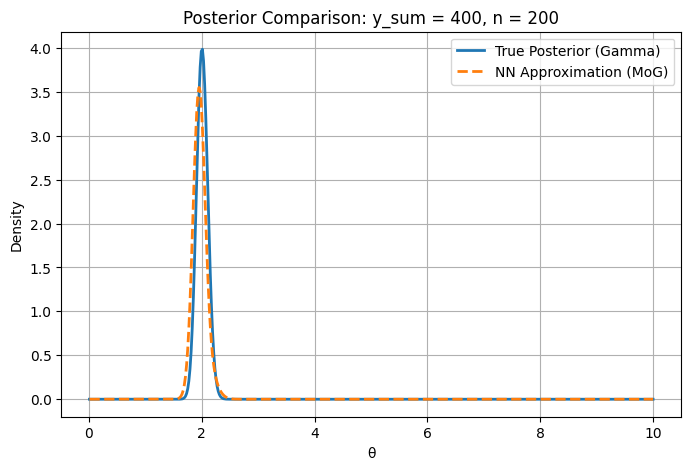

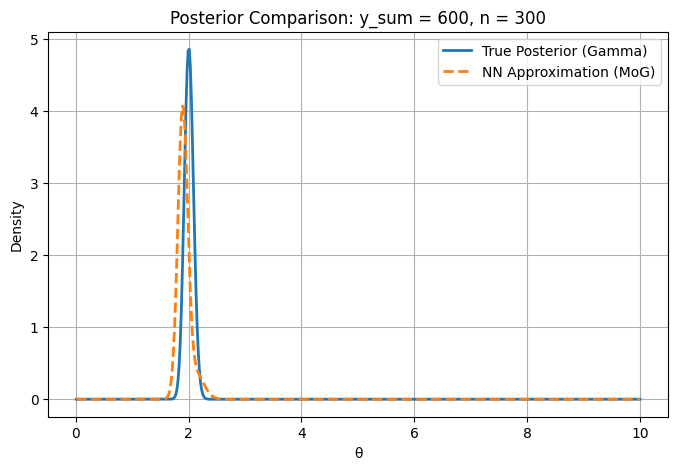

In [ ]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# Set random seed
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Gamma prior parameters
alpha = 4
beta_prior = 1
M = 500  # Simulation samples

# Simulate training data
n_values = list(range(10, 100, 10))  # From n = 10 to 90
df_final = pd.DataFrame()

for n in n_values:
    theta_samples = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
    y_sum_samples = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_samples]
    df = pd.DataFrame({
        'theta': theta_samples,
        'y_sum': y_sum_samples,
        'n': n
    })
    df_final = pd.concat([df_final, df], ignore_index=True)

# Prepare training pairs
unique_pairs = df_final[['y_sum', 'n']].drop_duplicates().reset_index(drop=True)
theta_lists = [
    df_final[(df_final['y_sum'] == row['y_sum']) & (df_final['n'] == row['n'])]['theta'].values
    for _, row in unique_pairs.iterrows()
]

# Mixture Density Network
class MixtureDensityNN(nn.Module):
    def __init__(self, K=3):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 16), nn.Tanh()
            
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.scale_head = nn.Sequential(
            nn.Linear(16, K),
            nn.Softplus()  # Ensure std > 0
        )

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        std = self.scale_head(h)
        return weights, mu, std

# Loss: negative log likelihood of Gaussian mixture
def mixture_log_likelihood(theta_vals, weights, mu, std):
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (torch.log(2 * torch.tensor(np.pi)) + 2 * torch.log(std) + ((theta - mu) ** 2) / (std ** 2))
    log_weighted = torch.log(weights + 1e-8) + log_probs
    log_sum_exp = torch.logsumexp(log_weighted, dim=1)
    return -log_sum_exp.mean()





### New Content####

def posterior_log_prob(theta_sample, pi, mu, std):
    theta = theta_sample.view(-1, 1).expand(-1, pi.shape[1])
    mu = mu.expand(theta.shape)
    std = std.expand(theta.shape)
    var = std ** 2
    log_component = -0.5 * ((theta - mu) ** 2) / var - torch.log(std + 1e-8) - 0.5 * np.log(2 * np.pi)
    log_pi = torch.log(pi + 1e-8)
    log_probs = torch.logsumexp(log_pi + log_component, dim=1)
    return log_probs

def posterior_structure_loss_KL(pi, mu, std, mle, fisher_var, num_samples=500):
    target_dist = Normal(loc=mle, scale=torch.sqrt(fisher_var))
    comp_ids = torch.multinomial(pi, num_samples, replacement=True).squeeze()
    sampled_mu = mu[0, comp_ids]
    sampled_std = std[0, comp_ids]
    eps = torch.randn_like(sampled_mu)
    theta_sample = (sampled_mu + eps * sampled_std).clamp(min=1e-4).view(-1, 1)
    mdn_logp = posterior_log_prob(theta_sample, pi, mu, std)
    gaussian_logp = target_dist.log_prob(theta_sample.squeeze())
    kl_reverse = torch.mean(mdn_logp - gaussian_logp)
    return kl_reverse
######## New Content




# Normalize input
model = MixtureDensityNN(K=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# New: structure loss weight (set 0 to disable)
lambda_struct = 0.5

# Training
for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for (y_val, n_val), theta_arr in zip(unique_pairs.values, theta_lists):
        if len(theta_arr) < 2 or np.var(theta_arr) == 0:
            continue
        x_feat = [y_val / n_val, np.log1p(y_val), np.log1p(n_val)]
        x_input = torch.tensor([x_feat], dtype=torch.float32)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
        weights, mu, std = model(x_input)
        nll_loss = mixture_log_likelihood(theta_vals, weights, mu, std)
        
        if n_val >= 50 and lambda_struct > 0:
            mle = torch.tensor(y_val / n_val, dtype=torch.float32)
            fisher_var = torch.tensor(y_val / (n_val ** 2), dtype=torch.float32)
            struct_loss = posterior_structure_loss_KL(weights, mu, std, mle, fisher_var)
        else:
            struct_loss = torch.tensor(0.0)
        loss = nll_loss + lambda_struct * struct_loss
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")


### Train with different weight of lambda

In [ ]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
from torch.distributions import Normal

# Set random seed
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Gamma prior parameters
alpha = 4
beta_prior = 1
M = 500

n_values = list(range(10, 100, 10))
df_final = pd.DataFrame()

for n in n_values:
    theta_samples = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
    y_sum_samples = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_samples]
    df = pd.DataFrame({
        'theta': theta_samples,
        'y_sum': y_sum_samples,
        'n': n
    })
    df_final = pd.concat([df_final, df], ignore_index=True)

unique_pairs = df_final[['y_sum', 'n']].drop_duplicates().reset_index(drop=True)
theta_lists = [
    df_final[(df_final['y_sum'] == row['y_sum']) & (df_final['n'] == row['n'])]['theta'].values
    for _, row in unique_pairs.iterrows()
]

class MixtureDensityNN(nn.Module):
    def __init__(self, K=3):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 16), nn.Tanh()
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.scale_head = nn.Sequential(
            nn.Linear(16, K),
            nn.Softplus()
        )

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        std = self.scale_head(h)
        return weights, mu, std

def mixture_log_likelihood(theta_vals, weights, mu, std):
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (torch.log(2 * torch.tensor(np.pi)) + 2 * torch.log(std) + ((theta - mu) ** 2) / (std ** 2))
    log_weighted = torch.log(weights + 1e-8) + log_probs
    log_sum_exp = torch.logsumexp(log_weighted, dim=1)
    return -log_sum_exp.mean()

def posterior_log_prob(theta_sample, pi, mu, std):
    theta = theta_sample.view(-1, 1).expand(-1, pi.shape[1])
    mu = mu.expand(theta.shape)
    std = std.expand(theta.shape)
    var = std ** 2
    log_component = -0.5 * ((theta - mu) ** 2) / var - torch.log(std + 1e-8) - 0.5 * np.log(2 * np.pi)
    log_pi = torch.log(pi + 1e-8)
    log_probs = torch.logsumexp(log_pi + log_component, dim=1)
    return log_probs

def posterior_structure_loss_KL(pi, mu, std, mle, fisher_var, num_samples=500):
    target_dist = Normal(loc=mle, scale=torch.sqrt(fisher_var))
    comp_ids = torch.multinomial(pi, num_samples, replacement=True).squeeze()
    sampled_mu = mu[0, comp_ids]
    sampled_std = std[0, comp_ids]
    eps = torch.randn_like(sampled_mu)
    theta_sample = (sampled_mu + eps * sampled_std).clamp(min=1e-4).view(-1, 1)
    mdn_logp = posterior_log_prob(theta_sample, pi, mu, std)
    gaussian_logp = target_dist.log_prob(theta_sample.squeeze())
    kl_reverse = torch.mean(mdn_logp - gaussian_logp)
    return kl_reverse

# === Training and saving models for different lambda_struct ===
lambda_list = [0.0, 0.5, 3.0, 5.0]

for lambda_struct in lambda_list:
    print(f"\n=== Training with lambda_struct = {lambda_struct} ===")
    model = MixtureDensityNN(K=3)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(600):
        model.train()
        loss_list = []

        for (y_val, n_val), theta_arr in zip(unique_pairs.values, theta_lists):
            if len(theta_arr) < 2 or np.var(theta_arr) == 0:
                continue
            x_feat = [y_val / n_val, np.log1p(y_val), np.log1p(n_val)]
            x_input = torch.tensor([x_feat], dtype=torch.float32)
            theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
            weights, mu, std = model(x_input)
            nll_loss = mixture_log_likelihood(theta_vals, weights, mu, std)

            if n_val >= 50 and lambda_struct > 0:
                mle = torch.tensor(y_val / n_val, dtype=torch.float32)
                fisher_var = torch.tensor(y_val / (n_val ** 2), dtype=torch.float32)
                struct_loss = posterior_structure_loss_KL(weights, mu, std, mle, fisher_var)
            else:
                struct_loss = torch.tensor(0.0)

            loss = nll_loss + lambda_struct * struct_loss
            loss_list.append(loss)

        if loss_list:
            total_loss = torch.stack(loss_list).mean()
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")

    torch.save(model.state_dict(), f"mdn_lambda_{lambda_struct}.pt")
    print(f"Saved model: mdn_lambda_{lambda_struct}.pt")

# === Final Comparison: Multiple Test Cases, Each with All λ Models ===
test_cases = [(150, 100), (300, 150), (600, 300), (900, 300)]
theta_range = np.linspace(0.01, 10.0, 500)

for y_obs, n_obs in test_cases:
    plt.figure(figsize=(10, 6))

    # True posterior
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_obs
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=3, color="black")

    for lambda_struct in lambda_list:
        model = MixtureDensityNN(K=3)
        model.load_state_dict(torch.load(f"mdn_lambda_{lambda_struct}.pt", weights_only=True))
        model.eval()

        x_feat = [y_obs / n_obs, np.log1p(y_obs), np.log1p(n_obs)]
        x_input = torch.tensor([x_feat], dtype=torch.float32)

        with torch.no_grad():
            weights, mu, std = model(x_input)

        approx_pdf = np.zeros_like(theta_range)
        for k in range(weights.shape[1]):
            pi_k = weights[0, k].item()
            mu_k = mu[0, k].item()
            std_k = std[0, k].item()
            approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

        plt.plot(theta_range, approx_pdf, lw=2, linestyle='--', label=f"λ = {lambda_struct}")

    plt.title(f"Posterior Comparison at y_sum = {y_obs}, n = {n_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fname = f"lambda_comparison_y{y_obs}_n{n_obs}.png"
    plt.savefig(fname)
    print(f"Saved plot: {fname}")
    plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10596f9a0>>
Traceback (most recent call last):
  File "/Users/zhangying/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 



=== Training with lambda_struct = 0.0 ===
Epoch 0, Loss: 9.50128


Evaluate with more pairs of (y_sum, n)

Saved plot: lambda_comparison_y150_n100.png


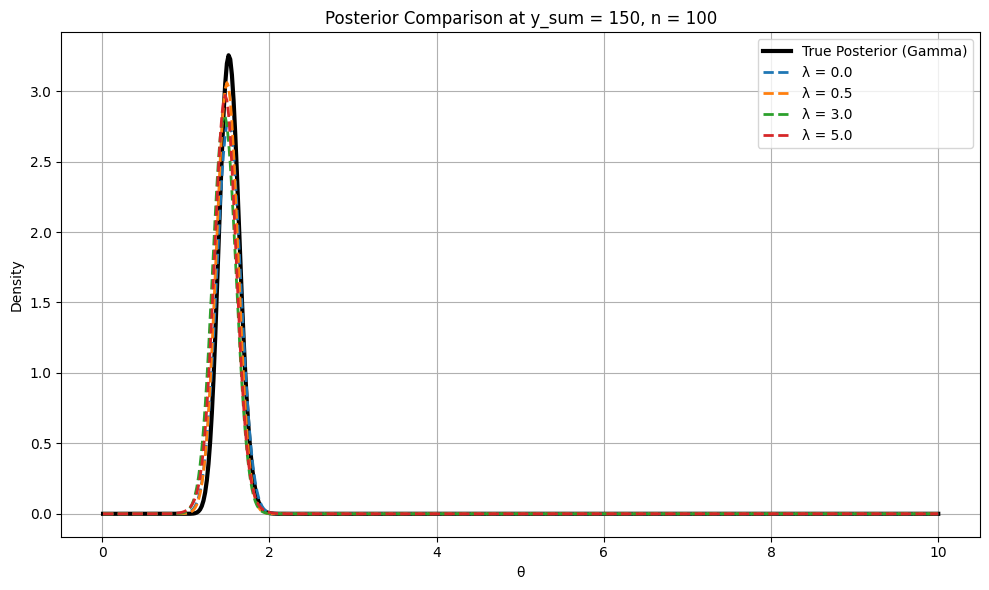

Saved plot: lambda_comparison_y300_n150.png


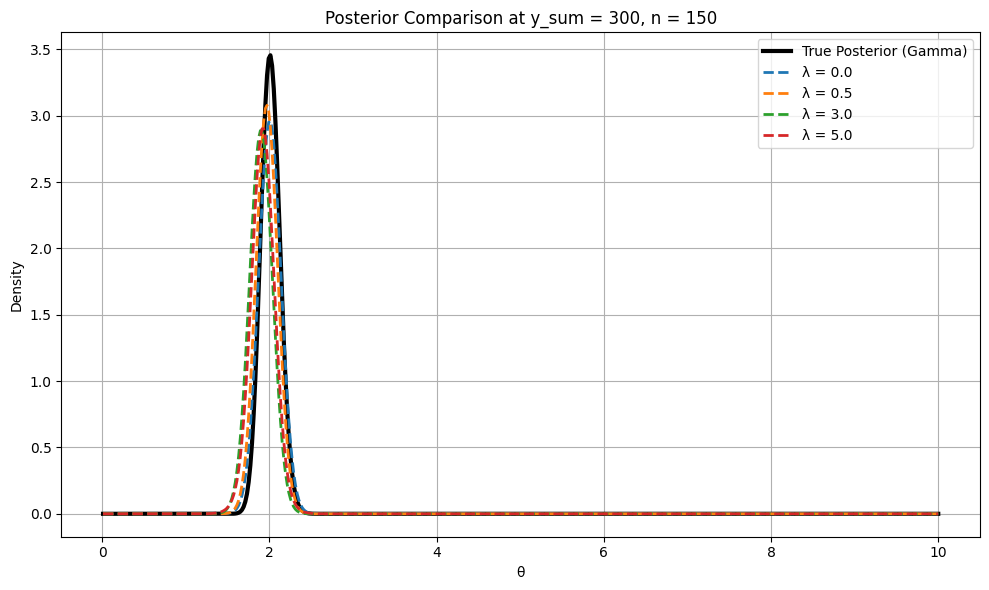

Saved plot: lambda_comparison_y600_n300.png


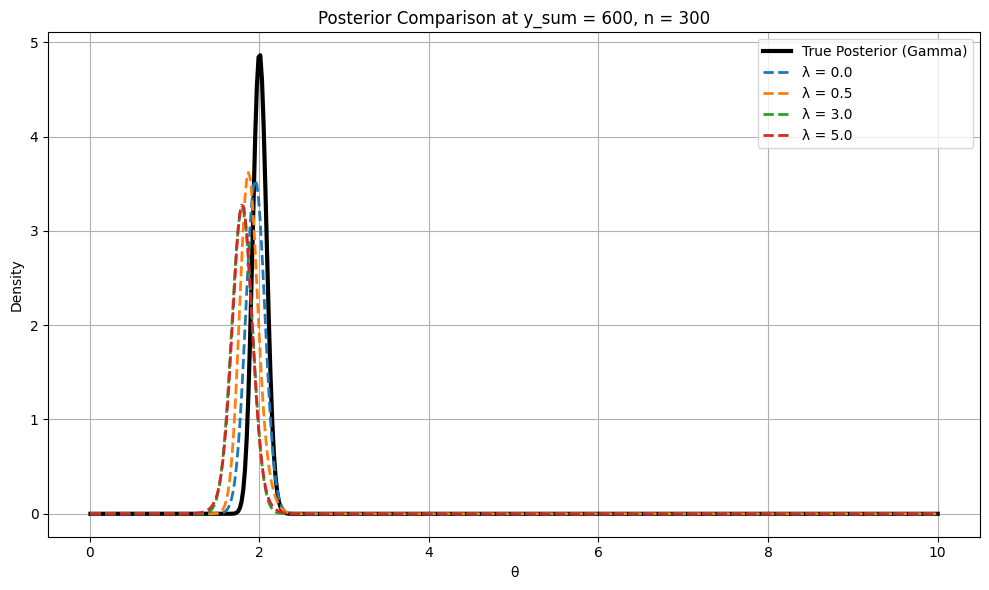

Saved plot: lambda_comparison_y900_n300.png


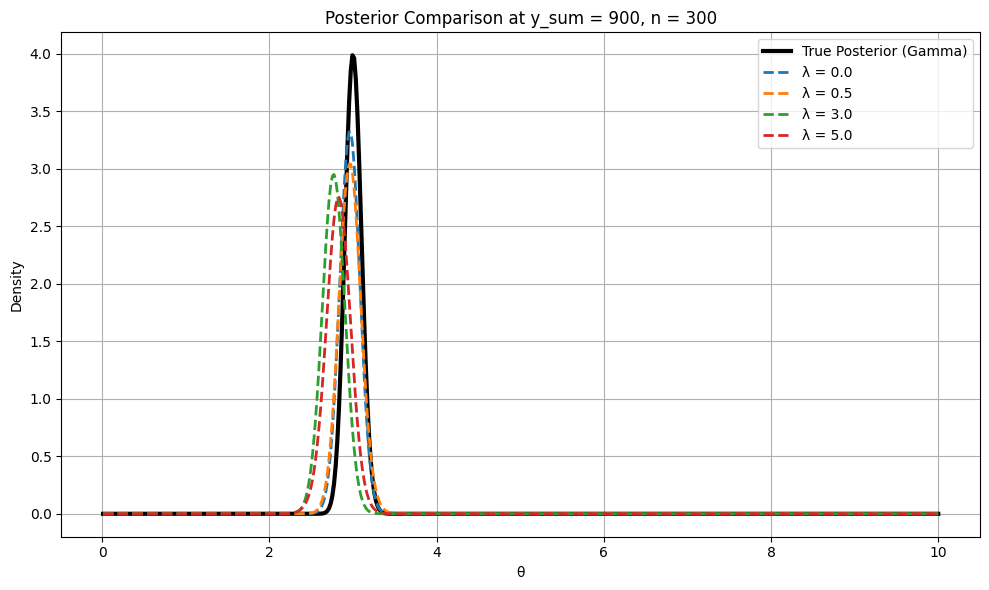

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from scipy.stats import gamma, norm

# ====== Configuration ======
alpha = 4
beta_prior = 1
lambda_list = [0.0, 0.5, 3.0, 5.0]
theta_range = np.linspace(0.01, 10.0, 500)
test_cases = [(150, 100), (300, 150), (600, 300), (900, 300)]

# ====== Define MDN Model (Must match training) ======
class MixtureDensityNN(nn.Module):
    def __init__(self, K=3):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 16), nn.Tanh()
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.scale_head = nn.Sequential(
            nn.Linear(16, K),
            nn.Softplus()
        )

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        std = self.scale_head(h)
        return weights, mu, std

# ====== Run Tests and Plot Comparisons ======
for y_obs, n_obs in test_cases:
    plt.figure(figsize=(10, 6))

    # True posterior: Gamma(alpha + y_sum, beta + n)
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_obs
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=3, color="black")

    # Input feature: [y/n, log(1+y), log(1+n)]
    x_feat = [y_obs / n_obs, np.log1p(y_obs), np.log1p(n_obs)]
    x_input = torch.tensor([x_feat], dtype=torch.float32)

    for lambda_struct in lambda_list:
        # Load the trained model
        model = MixtureDensityNN(K=3)
        model.load_state_dict(torch.load(f"mdn_lambda_{lambda_struct}.pt", weights_only=True))
        model.eval()

        with torch.no_grad():
            weights, mu, std = model(x_input)

        # Compute mixture of Gaussians PDF
        approx_pdf = np.zeros_like(theta_range)
        for k in range(weights.shape[1]):
            pi_k = weights[0, k].item()
            mu_k = mu[0, k].item()
            std_k = std[0, k].item()
            approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

        plt.plot(theta_range, approx_pdf, lw=2, linestyle='--', label=f"λ = {lambda_struct}")

    plt.title(f"Posterior Comparison at y_sum = {y_obs}, n = {n_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fname = f"lambda_comparison_y{y_obs}_n{n_obs}.png"
    plt.savefig(fname)
    print(f"Saved plot: {fname}")
    plt.show()
